The purpose of this notebook is identify peaks in a 1D XRD profile using some tools provided by pymatgen package.

* https://pymatgen.org/




# General imports

In [1]:
# We need to import some Python libraries here first.

import os
import sys
import shutil
import scipy
import time

import numpy as np
import xarray as xr


from IPython.display import clear_output


In [2]:
# We need import pyFAI,PyQt5,ipympl packages (if not available pip-install)


try:
    import pymatgen
except:
    !! pip install pymatgen
    import pymatgen


try:
    import ipympl
except:
    !! pip install ipympl

# if running on google colab
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

In [3]:
%matplotlib widget

# importing matplotlib for plots.
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.constrained_layout.use'] = True

# Setting up the example data path

In [4]:
# We assume this notebook and its data is on Google Drive so that we can use Google Colab.
# Otherwise, replace XXX with the exact path where this notebook (000.read_research_data_into_python.ipynb)
# and its data folder (000.read_research_data_into_python.data) is.

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/SULI-2024/repositories/pySULI/notebooks/')
    from google.colab import output
    output.enable_custom_widget_manager()

except Exception as exc:
    print(exc)
    os.chdir('.')

No module named 'google.colab'


In [5]:
# Assuming 002.learn_pyFAI.data folder is here.

here = os.getcwd()
example_data_path = '003.xrd_phase_identification_with_pymatgen.data'

# navigate into example_data_path directory
os.chdir(example_data_path)

os.listdir('.')

['unknown_xrd_2_wl=0.1824Angst.xy',
 'mix_CeO2_LaB6_wl=0.1820.xy',
 '_mp-files',
 '_match-cifs',
 'CeO2_wl=0.1820.xy',
 'unknown_xrd_1_wl=0.1824Angst.xy',
 'unknown_xrd_3_wl=0.1814Angst.xy',
 '_cifs',
 'LaB6_wl=0.1820.xy',
 '.ipynb_checkpoints',
 'unknown_xrd_4_wl=0.1814Angst.xy']

# Custom functions we will use in this example

The code below is essentially an abstraction of the pymatgen XRD tools into easily accesible methods for plotting XRD intensity peaks from crystal lattice information files. `hkl_plotter()` plots the calculated hkl pattern, based on the lattice constants and lattice angles provided by a crystal lattice information file. `phase_plotter` does the same thing, but for an array of different phases, calling `hkl_plotter()` for each phase.

The `hkl_plotter` can plot using a Crystallographic Information File (CIF or`.cif`), which is a file standard created by **The International Union of Crystallography**. A powerful feature of the `hkl_plotter()` method (which will be utilized in the cells to come) is its seamless integration of the **Materials Project API**, which allows you to seamlessly import crystaline structure files from their website using corresponding `mp-id` tags.

In [6]:
import pymatgen as mg
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure


def twotheta_to_q(twotheta, wavelength):
    twotheta = np.asarray(twotheta)
    wavelength = float(wavelength)
    pref = (4*np.pi)/wavelength
    return pref*np.sin(twotheta/2)

def q_to_twotheta(q, wavelength):
    q = np.asarray(q)
    wavelength=float(wavelength)
    pref = wavelength/(4*np.pi)
    return (2*np.arcsin(q*pref))

def q_to_d(q):
    return (2*np.pi)/np.asarray(q)

def d_to_q(d):
    return (2*np.pi)/np.asarray(d)

def twotheta_to_d(twotheta, wavelength):
    th = np.asarray(twotheta)/2
    rad = np.radians(th)
    t = 2*np.sin(rad)
    d = (wavelength)/t
    return d

def tth_wl1_to_wl2(tth1, wl1=0.187, wl2=0.4592):
    """
    scales TwoTheta1 with wavelength1 to TwoTheta1 with wavelength2
    """
    q = twotheta_to_q(np.deg2rad(tth_in), wl1)
    return np.rad2deg(q_to_twotheta(q, wl2))


def hkl_plotter(
    line_axes=None,
    stem_axes=None,
    mp_id=None,
    final=False,
    structure=None,
    str_file=None,
    label=None,
    marker="o",
    color="C0",
    label_x=0.9,
    label_y=0.9,
    unit="2th_deg",
    radial_range=(1, 16),
    bottom=-0.2,
    wl=0.77,
    scale=1,
    scale_a=1,
    scale_b=1,
    scale_c=1,
    export_cif_as=None,
    stem=True,
    stem_logscale=True,
    da_visible=None,
):

    if mp_id is not None:
        from mp_api.client import MPRester

        mpr = MPRester("dHgNQRNYSpuizBPZYYab75iJNMJYCklB")  ###
        structure = mpr.get_structure_by_material_id(mp_id, final=final)[0]
    elif structure is None:
        structure = Structure.from_file(str_file)

    structure.lattice = Lattice.from_parameters(
        a=structure.lattice.abc[0] * scale * scale_a,
        b=structure.lattice.abc[1] * scale * scale_b,
        c=structure.lattice.abc[2] * scale * scale_c,
        alpha=structure.lattice.angles[0],
        beta=structure.lattice.angles[1],
        gamma=structure.lattice.angles[2],
    )

    xrdc = XRDCalculator(wavelength=wl)  ###computes xrd pattern given wavelength , debye scherrer rings, and symmetry precision

    if unit == "q_A^-1":
        ps = xrdc.get_pattern(
            structure,
            scaled=True,
            two_theta_range=np.rad2deg(q_to_twotheta(radial_range, wl)),
        )
        X, Y = twotheta_to_q(np.deg2rad(ps.x), wl), ps.y
    elif unit == "2th_deg":
        ps = xrdc.get_pattern(structure, scaled=True, two_theta_range=radial_range)
        X, Y = ps.x, ps.y
    else:
        ps = xrdc.get_pattern(structure, scaled=True, two_theta_range=radial_range)
        X, Y = ps.x, ps.y

    for axl in line_axes:
        for i in X:
            axl.axvline(x=i, lw=0.6, color=color)
            axl.set_xlim([radial_range[0], radial_range[1]])

    for axs in stem_axes:
        axs_stem = axs.twinx()
        if stem:
            markerline, stemlines, baseline = axs_stem.stem(X, Y, markerfmt=".")
            plt.setp(stemlines, linewidth=0.5, color=color)
            plt.setp(markerline, color=color)
        axs_stem.set_xlim([radial_range[0], radial_range[1]])
        axs_stem.set_yticks([])
        axs_stem.set_ylim(bottom=0.1)
        axs_stem.text(
            label_x, label_y, label, color=color, transform=axs_stem.transAxes
        )

    if export_cif_as is not None:
        structure.to(fmt="cif", filename=export_cif_as)


def phase_plotter(
        wl,
        line_axes=[],
        stem_axes=[],
        radial_range=(1, 16),
        stem=True,
        y_shift=0.1,
        phases=[],
):
    for ep, phase in enumerate(phases):
        hkl_plotter(
            line_axes=line_axes,
            stem_axes=stem_axes,
            str_file=phase["cif"],
            label=phase["label"],
            scale=phase["scale"],
            marker="o",
            color="C%d" % ep,
            label_x=1.02,
            label_y=ep * y_shift,
            radial_range=radial_range,
            bottom=-0.2,
            wl=wl,
            stem=stem,
            stem_logscale=False,
        )

# Getting started with the custom functions

In the following examples, we will plot some sample experimental XRD intensity profiles. Alongside these intensity profiles we will plot CIF based hkl intensity peaks, to infer phase content in the sample data. We start by loading a CeO2 Intensity vs 2Theta data file, and plotting it.

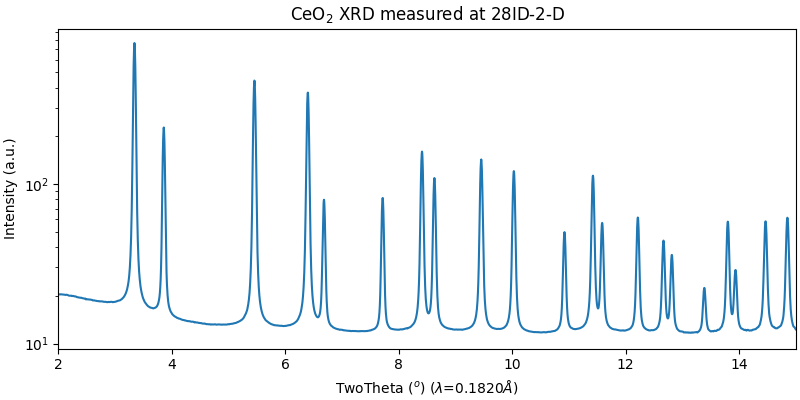

In [7]:
# here we first load xy file
data_xy = np.loadtxt('CeO2_wl=0.1820.xy',unpack=True)

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(1,1,1)
ax.plot(data_xy[0],data_xy[1])
ax.set_yscale('log')
ax.set_xlim([2,15])
ax.set_xlabel('TwoTheta ($^o$) ($\lambda$=0.1820$\AA$)')
ax.set_ylabel('Intensity (a.u.)')
ax.set_title('CeO$_2$ XRD measured at 28ID-2-D');

The `_cifs` folder in the `003.xrd_phase_identification_with_pymatgen.data` directory contains CIF files which we will utilize in the following cells. 

These files contain crystal lattice information. They can be visualized using the VESTA program:

* https://jp-minerals.org/vesta/en/

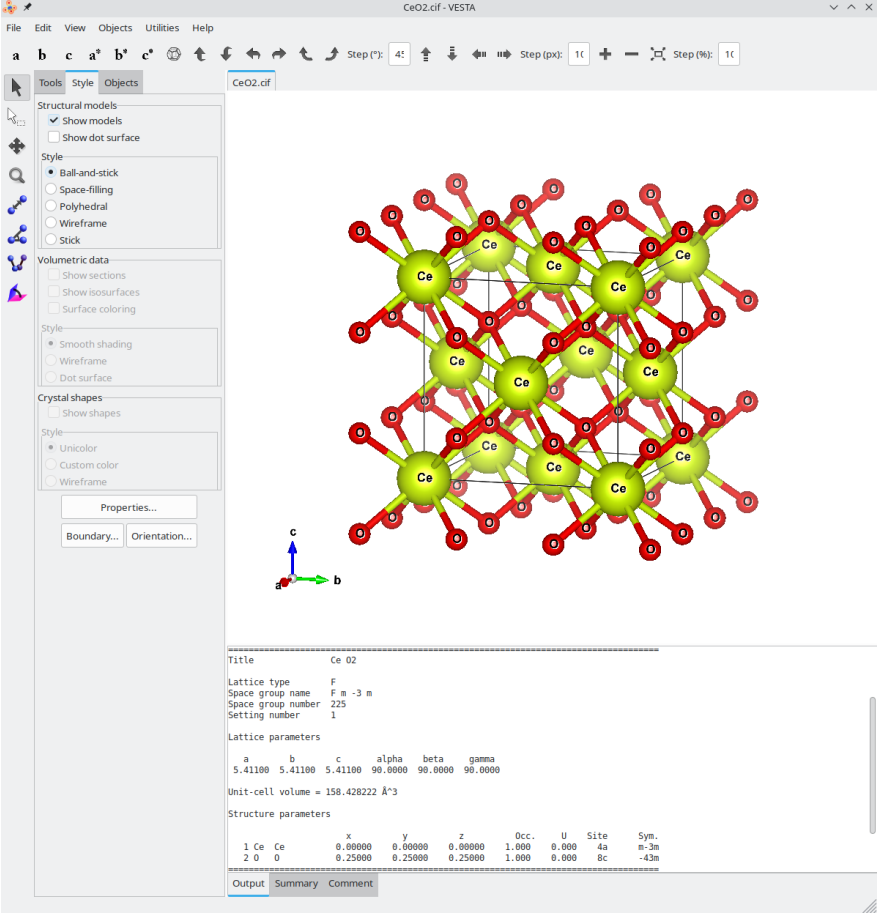

Below is an example of how we use the cif file above to plot expected hkls within a 1D pattern plot.
As expected, the measured 1D pattern matches nicely with the simulated hkls. 
Also, there are no unaccounted peaks which mean the measured sample is pure
within the detection limits of the experimental setup.

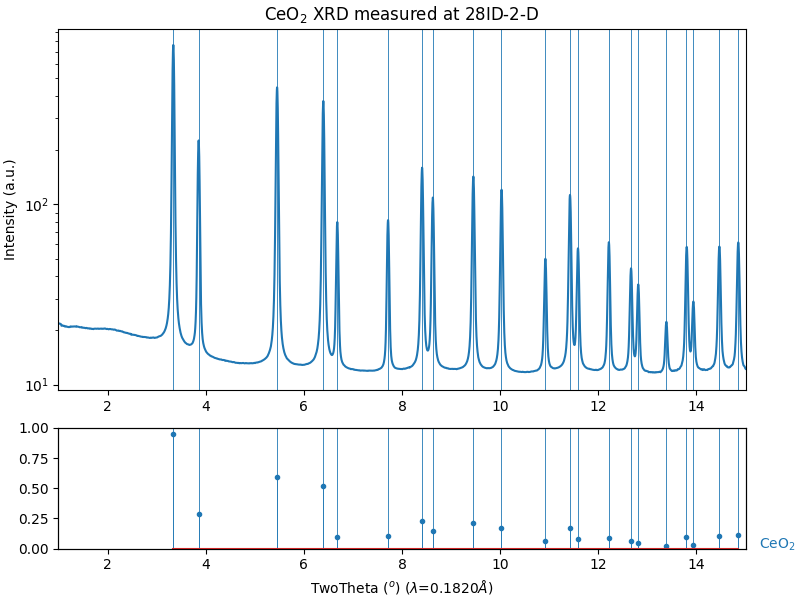

In [8]:
data_xy = np.loadtxt('CeO2_wl=0.1820.xy',unpack=True)

f, (ax, ax_bottom) = plt.subplots(2, 1, figsize=(8,6),
                                  gridspec_kw={'height_ratios': [3,1]},
                                  )

ax.plot(data_xy[0],data_xy[1])
ax.set_yscale('log')
ax.set_xlim([2,15])
ax.set_ylabel('Intensity (a.u.)')
ax.set_title('CeO$_2$ XRD measured at 28ID-2-D')

phase_plotter(
    wl=0.1820,
    line_axes=[ax,ax_bottom],
    stem_axes=[ax_bottom],
    radial_range=(1, 15),
    stem=True,
    y_shift=0.1,
    phases=[{"cif": '_cifs/CeO2.cif', "label": "CeO$_2$", "scale": 1}],
)
ax_bottom.set_xlabel('TwoTheta ($^o$) ($\lambda$=0.1820$\AA$)');

We repeat the same analysis for the LaB6 experimental data and its corresponding CIF file hkl peaks.

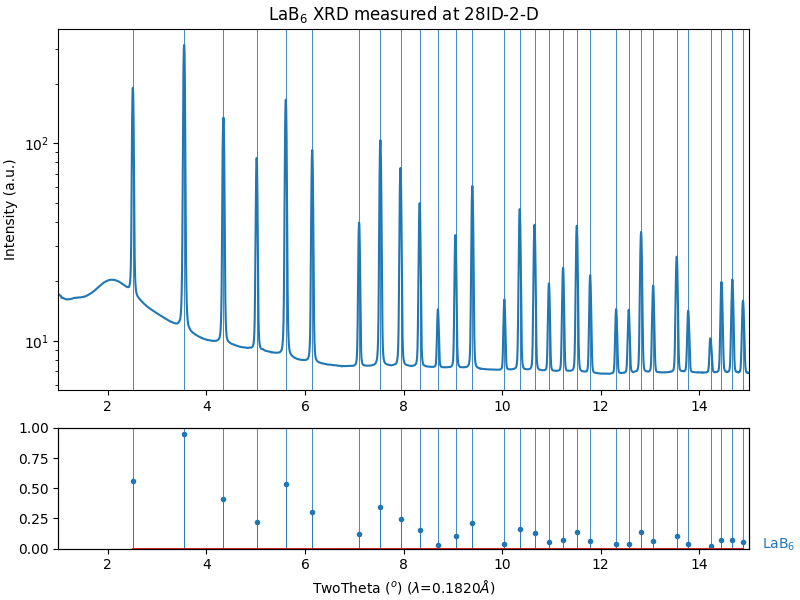

In [9]:
data_xy = np.loadtxt('LaB6_wl=0.1820.xy',unpack=True)

f, (ax, ax_bottom) = plt.subplots(2, 1, figsize=(8,6),
                                  gridspec_kw={'height_ratios': [3,1]},
                                  )

ax.plot(data_xy[0],data_xy[1])
ax.set_yscale('log')
ax.set_xlim([2,15])
ax.set_ylabel('Intensity (a.u.)')
ax.set_title('LaB$_6$ XRD measured at 28ID-2-D')

phase_plotter(
    wl=0.1820,
    line_axes=[ax,ax_bottom],
    stem_axes=[ax_bottom],
    radial_range=(1, 15),
    stem=True,
    y_shift=0.1,
    phases=[{"cif": '_cifs/LaB6.cif', "label": "LaB$_6$", "scale": 1}],
)
ax_bottom.set_xlabel('TwoTheta ($^o$) ($\lambda$=0.1820$\AA$)');

With multiple phases, we pass an array, `phases`, to the `phase_plotter()` method. Each element of the `phases` array is a dictionary, containing keys `cif`, `label`, and `scale`, and their corresponding values. We see good agreement with the expected phases LaB6 and CeO2.

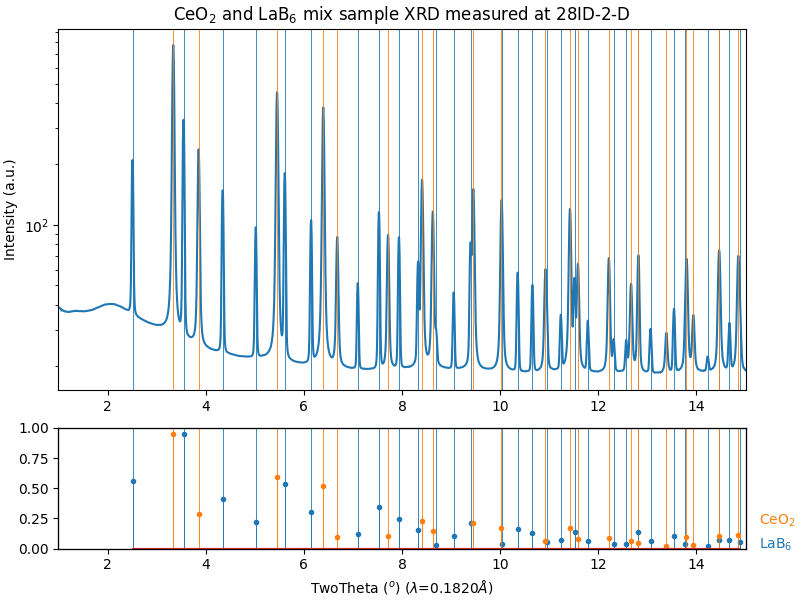

In [10]:
data_xy = np.loadtxt('mix_CeO2_LaB6_wl=0.1820.xy',unpack=True)

f, (ax, ax_bottom) = plt.subplots(2, 1, figsize=(8,6),
                                  gridspec_kw={'height_ratios': [3,1]},
                                  )

ax.plot(data_xy[0],data_xy[1])
ax.set_yscale('log')
ax.set_xlim([2,15])
ax.set_ylabel('Intensity (a.u.)')
ax.set_title('CeO$_2$ and LaB$_6$ mix sample XRD measured at 28ID-2-D')

phase_plotter(
    wl=0.1820,
    line_axes=[ax,ax_bottom],
    stem_axes=[ax_bottom],
    radial_range=(1, 15),
    stem=True,
    y_shift=0.2,
    phases=[{"cif": '_cifs/LaB6.cif', "label": "LaB$_6$", "scale": 1},
            {"cif": '_cifs/CeO2.cif', "label": "CeO$_2$", "scale": 1}],
)
ax_bottom.set_xlabel('TwoTheta ($^o$) ($\lambda$=0.1820$\AA$)');

# Let's attempt to match the unknown data files...

See the comments in the code below for a detailed description; in summary, to match phases from ,unknown data we plot all of the CIF file derived XRD patterns, along with the experimental data, and then one by one remove erroneous phases. In this example, we see good agreement with the data.

['CeO2.cif', 'Pt.cif', 'W.cif', 'Hematite (Fe2O3).cif', 'Cu.cif', 'Wustite (FeO).cif', 'Magnetite (Fe3O4).cif', 'alpha-Iron (Fe).cif', 'Ni.cif', 'Al2O3.cif', 'LaB6.cif']
[{'cif': '_cifs/Pt.cif', 'label': 'Pt', 'scale': 1}, {'cif': '_cifs/W.cif', 'label': 'W', 'scale': 1}, {'cif': '_cifs/Cu.cif', 'label': 'Cu', 'scale': 1}, {'cif': '_cifs/Ni.cif', 'label': 'Ni', 'scale': 1}, {'cif': '_cifs/Al2O3.cif', 'label': 'Al2O3', 'scale': 1}]


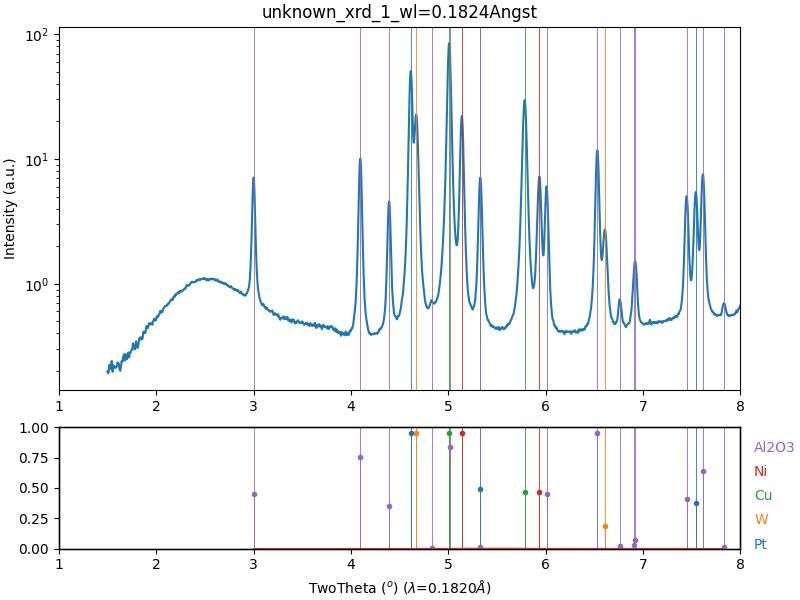

In [12]:
data_xy = np.loadtxt('unknown_xrd_1_wl=0.1824Angst.xy',unpack=True)

f, (ax, ax_bottom) = plt.subplots(2, 1, figsize=(8,6),
                                  gridspec_kw={'height_ratios': [3,1]},
                                  )

ax.plot(data_xy[0],data_xy[1])
ax.set_yscale('log')
ax.set_xlim([2,15])
ax.set_ylabel('Intensity (a.u.)')
ax.set_title('unknown_xrd_1_wl=0.1824Angst')

# get the name of each cif file in the _cifs directory order to search through them
ciffile_names = [filename for filename in os.listdir("./_cifs")]
for i in np.arange(len(ciffile_names)):
    if(not("cif" in ciffile_names[i])):
        ciffile_names.pop(i)
print(ciffile_names)

# saves a copy of the cif file name array, and then I remove phases
# judging by eye which ones are valid
phases_present = ciffile_names.copy()
phases_present.remove("Hematite (Fe2O3).cif")
phases_present.remove("Magnetite (Fe3O4).cif")        
phases_present.remove("LaB6.cif")   
phases_present.remove("CeO2.cif")
phases_present.remove("Wustite (FeO).cif")
phases_present.remove("alpha-Iron (Fe).cif")

# print out the present phases
all_phases = [{"cif":"_cifs/"+filename, "label":filename[:-4], "scale":1} for filename in phases_present]
print(all_phases)


# plots phases using method from earlier
phase_plotter(
    wl=0.1824,
    line_axes=[ax,ax_bottom],
    stem_axes=[ax_bottom],
    radial_range=(1, 8),
    stem=True,
    y_shift=0.2,
    phases=all_phases
)
ax_bottom.set_xlabel('TwoTheta ($^o$) ($\lambda$=0.1820$\AA$)');

Here, we are doing the same thing as above, for a second example, but unfortunately the agreement isn't great.

[{'cif': '_cifs/Hematite (Fe2O3).cif', 'label': 'Hematite (Fe2O3)', 'scale': 1}, {'cif': '_cifs/Wustite (FeO).cif', 'label': 'Wustite (FeO)', 'scale': 1}, {'cif': '_cifs/Magnetite (Fe3O4).cif', 'label': 'Magnetite (Fe3O4)', 'scale': 1}]


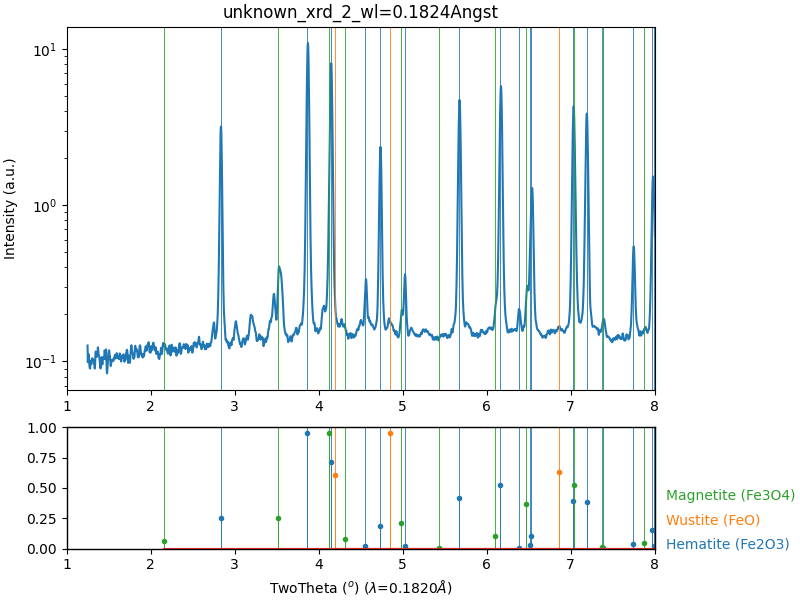

In [13]:
data_xy = np.loadtxt('unknown_xrd_2_wl=0.1824Angst.xy',unpack=True)

f, (ax, ax_bottom) = plt.subplots(2, 1, figsize=(8,6),
                                  gridspec_kw={'height_ratios': [3,1]},
                                  )

ax.plot(data_xy[0],data_xy[1])
ax.set_yscale('log')
ax.set_xlim([2,15])
ax.set_ylabel('Intensity (a.u.)')
ax.set_title('unknown_xrd_2_wl=0.1824Angst')

phases_present = ciffile_names.copy()
phases_present.remove("Pt.cif")
phases_present.remove("Ni.cif")
phases_present.remove("LaB6.cif")
phases_present.remove("Cu.cif")
#phases_present.remove("Magnetite (Fe3O4).cif")        
phases_present.remove("Al2O3.cif")   
phases_present.remove("CeO2.cif")
phases_present.remove("W.cif")
#phases_present.remove("Wustite (FeO).cif")
phases_present.remove("alpha-Iron (Fe).cif")

all_phases = [{"cif":"_cifs/"+filename, "label":filename[:-4], "scale":1} for filename in phases_present]
print(all_phases)



phase_plotter(
    wl=0.1824,
    line_axes=[ax,ax_bottom],
    stem_axes=[ax_bottom],
    radial_range=(1, 8),
    stem=True,
    y_shift=0.2,
    phases=all_phases
)
ax_bottom.set_xlabel('TwoTheta ($^o$) ($\lambda$=0.1820$\AA$)');

Now, for our third example, we could not find a good match among our selection of CIF files, so instead we use the Match! phase analysis software to find the phases. Luckily, Match! allows us to export the phases we find as a CIF file, and we import that CIF file in the code below, and we see good agreement again.

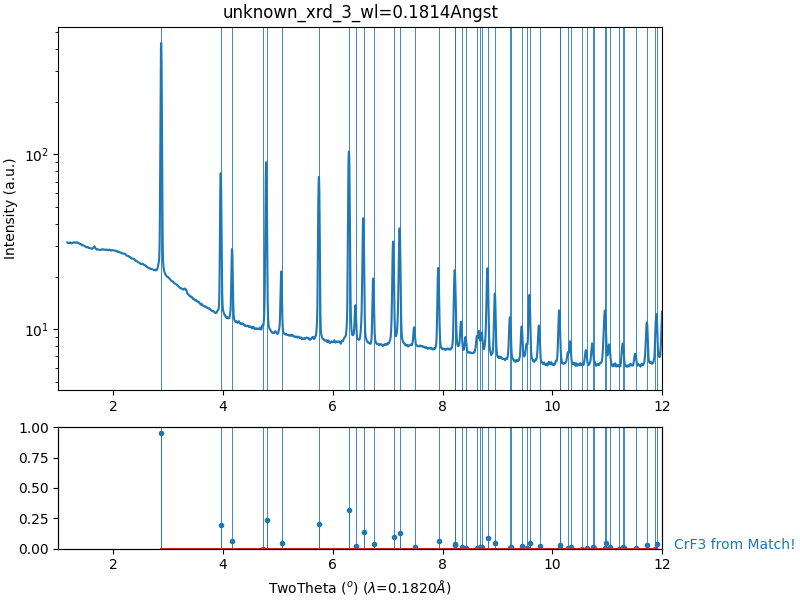

In [15]:
data_xy = np.loadtxt('unknown_xrd_3_wl=0.1814Angst.xy',unpack=True)

f, (ax, ax_bottom) = plt.subplots(2, 1, figsize=(8,6),
                                  gridspec_kw={'height_ratios': [3,1]},
                                  )

ax.plot(data_xy[0],data_xy[1])
ax.set_yscale('log')
ax.set_xlim([2,15])
ax.set_ylabel('Intensity (a.u.)')
ax.set_title('unknown_xrd_3_wl=0.1814Angst')

# cif file from Match! XRD phase analysis software
phases_present = ["unknown_data_3.cif"]

all_phases = [{"cif":"_match-cifs/"+filename, "label":"CrF3 from Match!", "scale":1} for filename in phases_present]

phase_plotter(
    wl=0.1814,
    line_axes=[ax,ax_bottom],
    stem_axes=[ax_bottom],
    radial_range=(1, 12),
    stem=True,
    y_shift=0.2,
    phases=all_phases
)
ax_bottom.set_xlabel('TwoTheta ($^o$) ($\lambda$=0.1820$\AA$)');

Now, for the fourth example, no CIF derived phases seem to fit well for our given CIF files. Maybe we need to look through additional CIFs, or maybe we need to adjust the scales for the given CIFs we have. 

[{'cif': '_cifs/CeO2.cif', 'label': 'CeO2', 'scale': 1}, {'cif': '_cifs/Pt.cif', 'label': 'Pt', 'scale': 1}, {'cif': '_cifs/W.cif', 'label': 'W', 'scale': 1}, {'cif': '_cifs/Hematite (Fe2O3).cif', 'label': 'Hematite (Fe2O3)', 'scale': 1}, {'cif': '_cifs/Cu.cif', 'label': 'Cu', 'scale': 1}, {'cif': '_cifs/Wustite (FeO).cif', 'label': 'Wustite (FeO)', 'scale': 1}, {'cif': '_cifs/Magnetite (Fe3O4).cif', 'label': 'Magnetite (Fe3O4)', 'scale': 1}, {'cif': '_cifs/alpha-Iron (Fe).cif', 'label': 'alpha-Iron (Fe)', 'scale': 1}, {'cif': '_cifs/Ni.cif', 'label': 'Ni', 'scale': 1}, {'cif': '_cifs/Al2O3.cif', 'label': 'Al2O3', 'scale': 1}, {'cif': '_cifs/LaB6.cif', 'label': 'LaB6', 'scale': 1}]


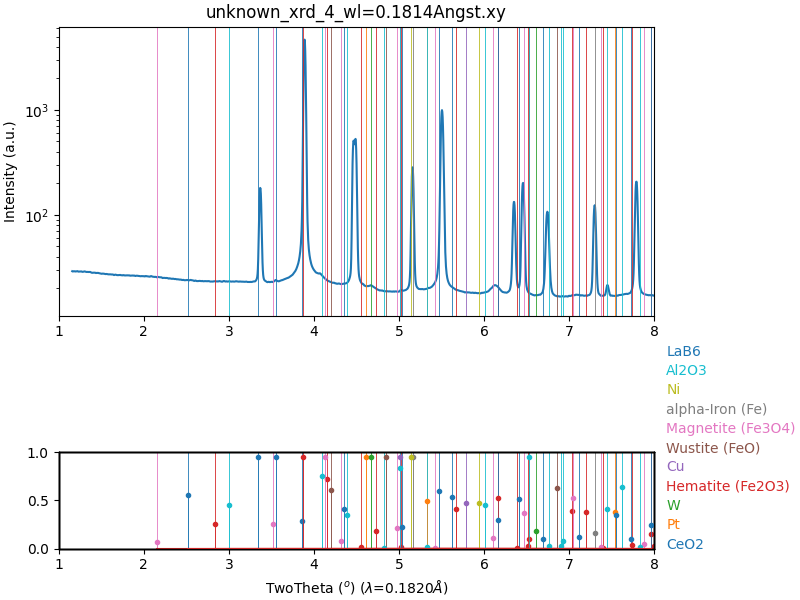

In [16]:
data_xy = np.loadtxt('unknown_xrd_4_wl=0.1814Angst.xy',unpack=True)

f, (ax, ax_bottom) = plt.subplots(2, 1, figsize=(8,6),
                                  gridspec_kw={'height_ratios': [3,1]},
                                  )

ax.plot(data_xy[0],data_xy[1])
ax.set_yscale('log')
ax.set_xlim([2,15])
ax.set_ylabel('Intensity (a.u.)')
ax.set_title('unknown_xrd_4_wl=0.1814Angst.xy')

phases_present = ciffile_names.copy()
#phases_present.remove("Pt.cif")
#phases_present.remove("Ni.cif")
#phases_present.remove("LaB6.cif")
#phases_present.remove("Cu.cif")
#phases_present.remove("Magnetite (Fe3O4).cif")        
#phases_present.remove("Al2O3.cif")   
#phases_present.remove("CeO2.cif")
#phases_present.remove("W.cif")
#phases_present.remove("Wustite (FeO).cif")
#phases_present.remove("alpha-Iron (Fe).cif")

all_phases = [{"cif":"_cifs/"+filename, "label":filename[:-4], "scale":1} for filename in phases_present]
print(all_phases)



phase_plotter(
    wl=0.1824,
    line_axes=[ax,ax_bottom],
    stem_axes=[ax_bottom],
    radial_range=(1, 8),
    stem=True,
    y_shift=0.2,
    phases=all_phases
)
ax_bottom.set_xlabel('TwoTheta ($^o$) ($\lambda$=0.1820$\AA$)');

Now that we know that example 3 corresponds to CrF3, we can practice using the **Materials Project API** to identify the phase. We import the API as `mp_api`, and then use the `hkl_plotter()` with `mp_id = "mp-560338"`, which corresponds to the CrF3 file on the **Materials Project** website. 

Here is an example material from the **Materials Project** website: <https://next-gen.materialsproject.org/materials/mp-1071448>; if we instead set `mp_id = "mp-1071448"`, we can see the intensity peaks for the XRD pattern for this particular material. The API does all the work for you!

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

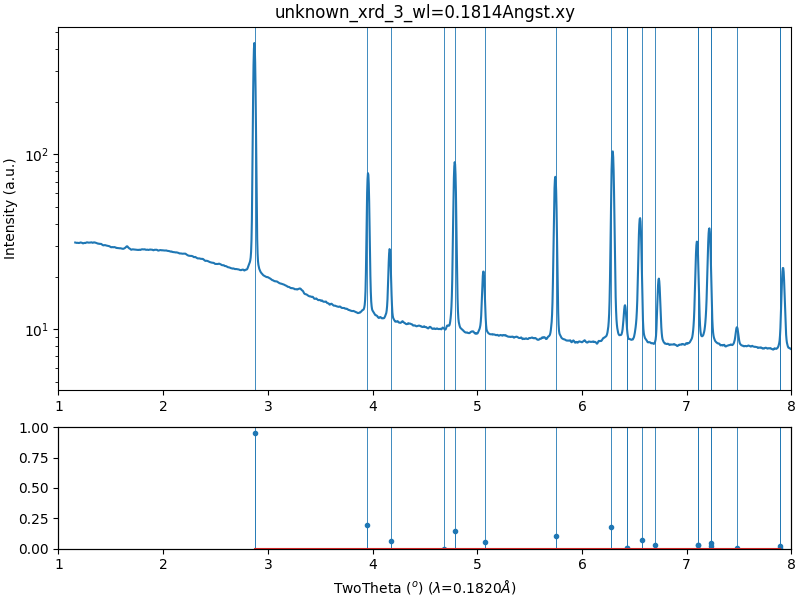

In [17]:
import mp_api

data_xy = np.loadtxt('unknown_xrd_3_wl=0.1814Angst.xy',unpack=True)

f, (ax, ax_bottom) = plt.subplots(2, 1, figsize=(8,6),
                                  gridspec_kw={'height_ratios': [3,1]},
                                  )

ax.plot(data_xy[0],data_xy[1])
ax.set_yscale('log')
ax.set_xlim([2,15])
ax.set_ylabel('Intensity (a.u.)')
ax.set_title('unknown_xrd_3_wl=0.1814Angst.xy')

hkl_plotter(
    line_axes=[ax,ax_bottom],
    stem_axes=[ax_bottom],
    mp_id = "mp-560338", #"mp-1071448"`
    radial_range=(1, 8),
    stem=True,
    unit="q_A^-1",
    scale=0.6
)

ax_bottom.set_xlabel('TwoTheta ($^o$) ($\lambda$=0.1820$\AA$)');
